# RA2CE feature: Equity analysis

This notebook is a rather technical notebook. The recommended user is a user with background knowledge of network criticality. 

In this notebook, we will perform criticality analysis with three different distributive principles: utilitarian, egalitarian and prioritarian principles. For more background knowledge on these principles and the application on transport network criticality analysis, please read: https://www.sciencedirect.com/science/article/pii/S0965856420308077 

The purpose of the equity analysis performd in this notebook is providing insight into how different distributive principles can result in different prioritizations of the network. While we usually prioritize network interventions based on the number of people that use the road, equity principles allow us to also take into account the function of the network for for example underpriviliged communities. 
Depending on the equity principle applied, your network prioritization might change, which can change decision-aking.

The RA2CE analysis is set up generically. The user can determine the equity weights themselves. This can for example be GINI-coefficients or social vulnerability scores. The user-defined equity weights will feed into the prioritarian principle.

The three applied principles are explained below:

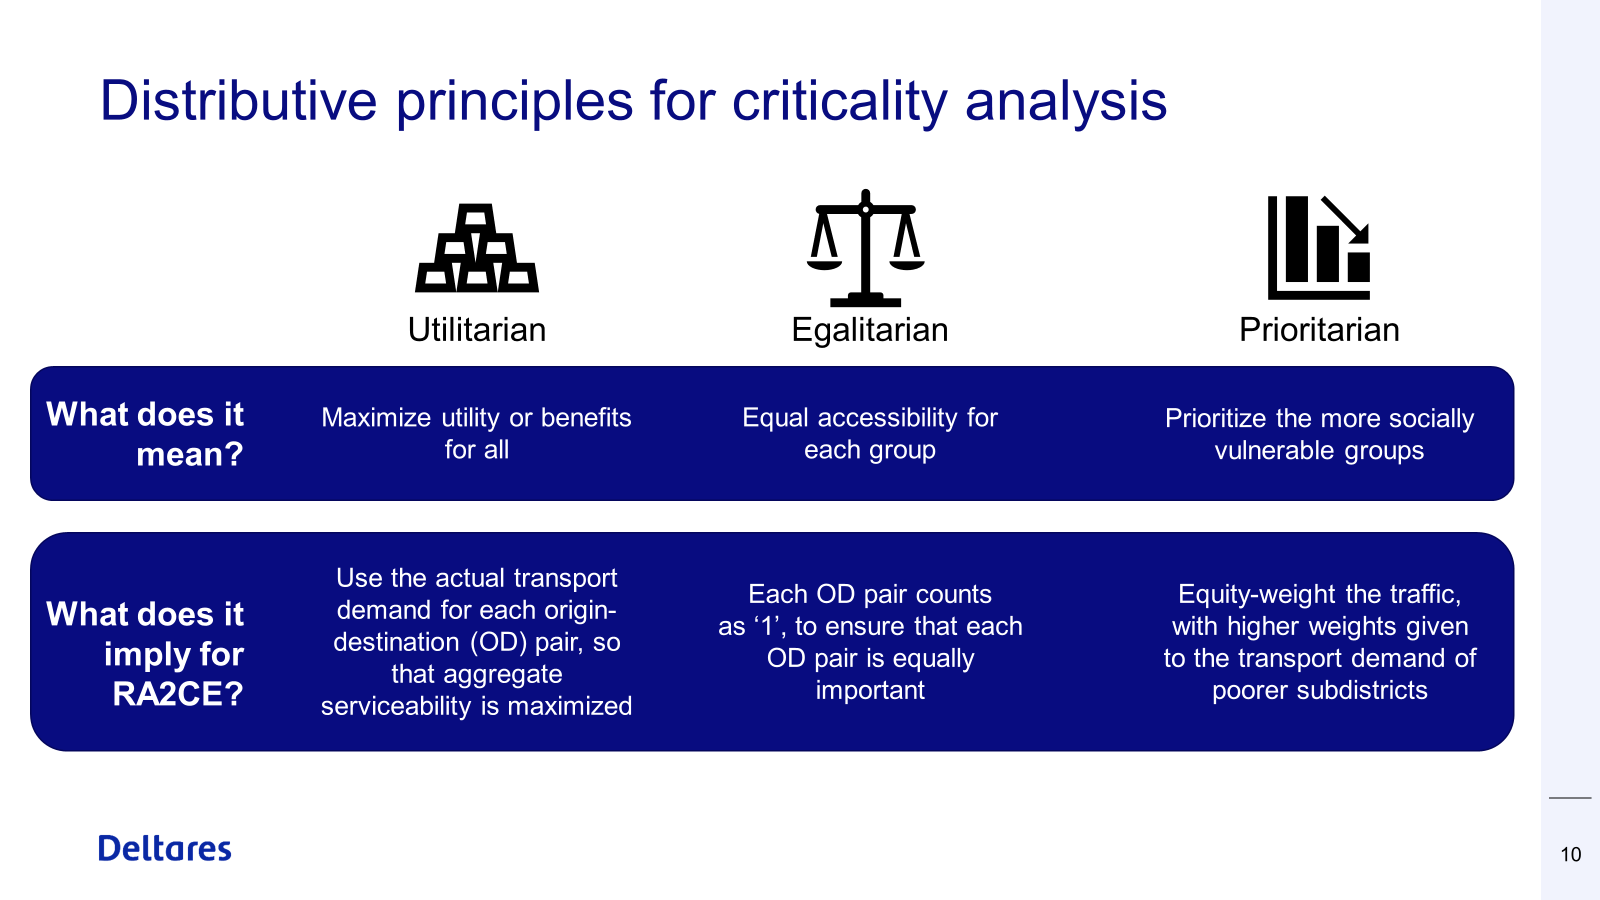

### For new users

If you have not checked out the previous RA2CE examples and you want to run your own RA2CE analysis, we advise you to first familiarize yourself with those notebooks. In this current notebook we will not provide extensive explanations as to how to run RA2CE and create the correct setups. We will assume the user has this knowledge already. 

# Imports

Packages import

In [1]:
import ast
import random
import sys
import webbrowser
import geopandas as gpd
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib.colors import to_hex
from pathlib import Path
import rasterio
import folium

Set the path to your equity analysis data folder

In [2]:
root_dir = Path("data", "equity_analysis")
assert root_dir.exists()

# Inspect data and get familiar with the use-case

We will first show you the data that will be used in this use case on Pontianak Indonesia

### 1. Using equity weights to delineate more vulnerable areas

For the equity analysis, the user can assign equity weights which can be used in the criticality analysis. In this analysis we use a region weights file (region_weight.csv) which holds weights for specific areas in Pontianak Indonesia. You then also need a shapefile delineating the regions in question. We will inspect both files in this example and see which areas of Pontianak are more vulnerable according to this user-specified equity-weight file

In [3]:
# load the files
path_network = root_dir / "static" / "network"
path_region_weights = path_network / "region_weight.csv"
path_regions = path_network / "region.shp"

region_weigths = pd.read_csv(path_region_weights, sep=';')
regions = gpd.read_file(path_regions, driver = "SHP")

#Merge the shapefile and the weights csv file:
region_weights_plot = pd.merge(regions, region_weigths, left_on='DESA', right_on='region')


Which regions are more vulnerable?

In [4]:
#Inspect the regions
region_weights_plot.explore(column='weight', cmap='Reds', tiles="CartoDB positron")

### 2. Inspect origins, destinations and the road network

Load the origins and destinations data and the road network of our analysis

In [5]:
path_network = root_dir / "static" / "network"
path_origins = path_network / "origins_points.shp"
path_destinations = path_network / "osm_health_point.shp"
origins = gpd.read_file(path_origins, driver = "SHP")
destinations = gpd.read_file(path_destinations, driver = "SHP")

Inspect origins (blue) and health destinations (red)

In [6]:
m = origins.explore(color='blue', tiles="CartoDB positron", name='WorldPop origins')
m = destinations.explore(m=m, color="red", name="Health destinations")
# this is completely optional
folium.LayerControl().add_to(m)
m


# Running the RA2CE analysis

### 1. Make sure your data is created and stored correctly

See the origins/destinations example to familiarize yourself with how to set up origins and destinations files. Inspect the regions file and the region_weight file and make sure they are saved in the correct folder

### 2. Set up your network and analysis ini

Before you start running, you need to make sure that your .ini files contain the right parameters. Check out the analysis and network.ini files in the data folder to check the additional parameters that need to be set to run this example! Below we paste a snippet of these files as example

**Network Ini update section origins_destinations**<br>
[origins_destinations]<br>
origins = origins_points.shp # Must be in the static/network folder, belongs to this analysis <br>
destinations = osm_health_point.shp # gis_osm_pois_pontianak.shp # Must be in the static/network folder, belongs to this analysis<br>
origins_names = A<br>
destinations_names = B<br>
id_name_origin_destination = OBJECTID #default if origins is a tif file = OBJECTID<br>
origin_count = values #necessary if traffic on each edge would be recorded in optimal_route_origin_destination<br>
origin_out_fraction = 1<br>
category = category<br>
region = region.shp #necessary for distributional / equity analysis<br>
region_var = DESA #necessary for distributional / equity analysis<br>

**analysis_ini update optimal_route_origin_destination analysis**<br>
[analysis1]<br>
name = optimal route origin destination<br>
analysis = optimal_route_origin_destination<br>
weighing = length<br>
save_traffic = True #True if you want to record the traffic in each edge<br>
equity_weight = region_weight.csv #equity-weighted factors for each region, should be stored in static/network. Note that 'region' and 'region_var' should present in network.ini<br>
save_gpkg = True<br>
save_csv = True<br>



### 3. Find your folder and initalization files

Now we can start our RA2CE analysis. Let's initialize RA2CE first

In [7]:
from ra2ce.ra2ce_handler import Ra2ceHandler #import the ra2cehandler to run ra2ce analyses

_network_ini_name = "network.ini" #set the name for the network.ini
_analysis_ini_name = "analyses.ini" #set the name for the analysis.ini

c:\Users\meije_le\Anaconda3\envs\ra2ce_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Check if the network.ini and analysis.ini indeed exist

In [8]:
network_ini = root_dir / _network_ini_name
assert network_ini.is_file()

analysis_ini = root_dir / _analysis_ini_name
assert analysis_ini.is_file()

### 4. Run RA2CE

In [9]:
handler = Ra2ceHandler(network=network_ini, analysis=analysis_ini)
handler.configure()
handler.run_analysis()

2024-03-13 11:14:23 AM - [ra2ce_logging.py:41] - root - INFO - RA2CE logger initialized.
2024-03-13 11:14:23 AM - [networks.py:186] - root - INFO - Apparently, you already did create a network with ra2ce earlier. Ra2ce will use this: data\equity_analysis\static\output_graph\base_graph.p
2024-03-13 11:14:23 AM - [analyses_indirect.py:1090] - root - INFO - ----------------------------- Started analyzing 'optimal route origin destination'  -----------------------------
Finding optimal routes.: 100%|██████████| 540/540 [00:03<00:00, 136.62it/s]
2024-03-13 11:14:36 AM - [analyses_indirect.py:1386] - root - INFO - Results saved to: data\equity_analysis\output\optimal_route_origin_destination\optimal_route_origin_destination.gpkg
2024-03-13 11:14:37 AM - [analyses_indirect.py:1362] - root - INFO - ----------------------------- Analysis 'optimal route origin destination' finished. Time: 13.44s  -----------------------------


# Post-processing results

The result of the equity analysis will be saved into the 'output' folder, under the specified analysis 'optimal_route_origin_destination'. This is a .csv file without geometry. To plot the results below, we will first add geometry to this data prior to showing the results

####  1. Load the traffic analysis output data

In [10]:
optimal_route = root_dir/'output'/'optimal_route_origin_destination'
optimal_route_graph = optimal_route / "optimal_route_origin_destination_link_traffic.csv"
traffic = pd.read_csv(optimal_route_graph)
df = traffic.copy()
df.head()

,u,v,traffic,traffic_egalitarian,traffic_prioritarian
0,10736480824,1906180830,4549.779297,5.0,14212.096079
1,1906180830,10736480825,31950.635376,50.0,45468.956352
2,10736480825,10736480837,35600.869019,55.0,49119.189995
3,10736480837,10736480838,42651.551636,60.0,71143.330561
4,10736480838,10736480852,48254.479858,65.0,76746.258783


#### 2. Load the origin_destination graph edges that hold geometry

In [11]:
path_output_graph = root_dir / "static" / "output_graph"
base_graph_edges = path_output_graph / "origins_destinations_graph_edges.gpkg"
edges_gdf = gpd.read_file(base_graph_edges, driver = "GPKG")
gdf = edges_gdf.copy()
edges_gdf.head()

,u,v,key,oneway,name,highway,reversed,length,rfid_c,rfid,bridge,junction,lanes,width,access,osmid_original,geometry
0,559431729,1848302290,0,True,Jalan Agus Salim,tertiary,False,9.0,4,1,nan,nan,nan,nan,nan,782412294,"LINESTRING (109.33922 -0.02962, 109.33915 -0.0..."
1,559431729,559431731,0,True,Jalan Gajah Mada,tertiary,False,127.0,"[1425, 3, 2765, 6534]",2,nan,nan,nan,nan,nan,43996468,"LINESTRING (109.33922 -0.02962, 109.33930 -0.0..."
2,559431729,1977410506,0,True,nan,tertiary,False,14.0,883,97,nan,nan,nan,nan,nan,575398528,"LINESTRING (109.33922 -0.02962, 109.33916 -0.0..."
3,559431729,1977410544,0,True,Jalan Agus Salim,tertiary,False,74.0,"[6530, 909]",106,nan,nan,nan,nan,nan,43996479,"LINESTRING (109.33976 -0.02924, 109.33934 -0.0..."
4,559431731,5891888009,0,True,Jalan Gajah Mada,tertiary,False,187.0,"[992, 993, 2144, 3939, 5, 3886, 6043, 2143]",3,nan,nan,nan,nan,nan,43996468,"LINESTRING (109.33975 -0.03064, 109.33989 -0.0..."


#### 3. Merge analysis data with geometry 

In [12]:
for var in ['traffic', 'traffic_egalitarian', 'traffic_prioritarian']:
    gdf[var] = 0
    
    # Create a dictionary to store the values for faster lookup
    var_values = dict(zip(zip(df['u'], df['v']), df[var]))

    for u, v in zip(df['u'], df['v']):
        if u != v:
            # Check if the edge (u, v) exists in the DataFrame
            if (u, v) in var_values:
                gdf.loc[(gdf['u'] == u) & (gdf['v'] == v), var] = var_values[(u, v)]
                
                # Check if the reverse edge (v, u) exists and hasn't been assigned a value yet
                if (v, u) not in var_values:
                    gdf.loc[(gdf['u'] == v) & (gdf['v'] == u), var] = var_values[(u, v)]
            else:
                # If the edge doesn't exist in the DataFrame, check if the reverse edge does
                if (v, u) in var_values:
                    gdf.loc[(gdf['u'] == v) & (gdf['v'] == u), var] = var_values[(v, u)]


#### 4. Rank the edges based on the different traffic analysis results

In [13]:
gdf['traffic_ranked'] = gdf['traffic'].rank(method='min', ascending=False)
gdf['traffic_egalitarian_ranked'] = gdf['traffic_egalitarian'].rank(method='min', ascending=False)
gdf['traffic_prioritarian_ranked'] = gdf['traffic_prioritarian'].rank(method='min', ascending=False)

# Visualize results

The darker the edge, the higher its ranking, the more critical the network part 

Ranking 1 is the highest ranking, higher values represent lower rankings

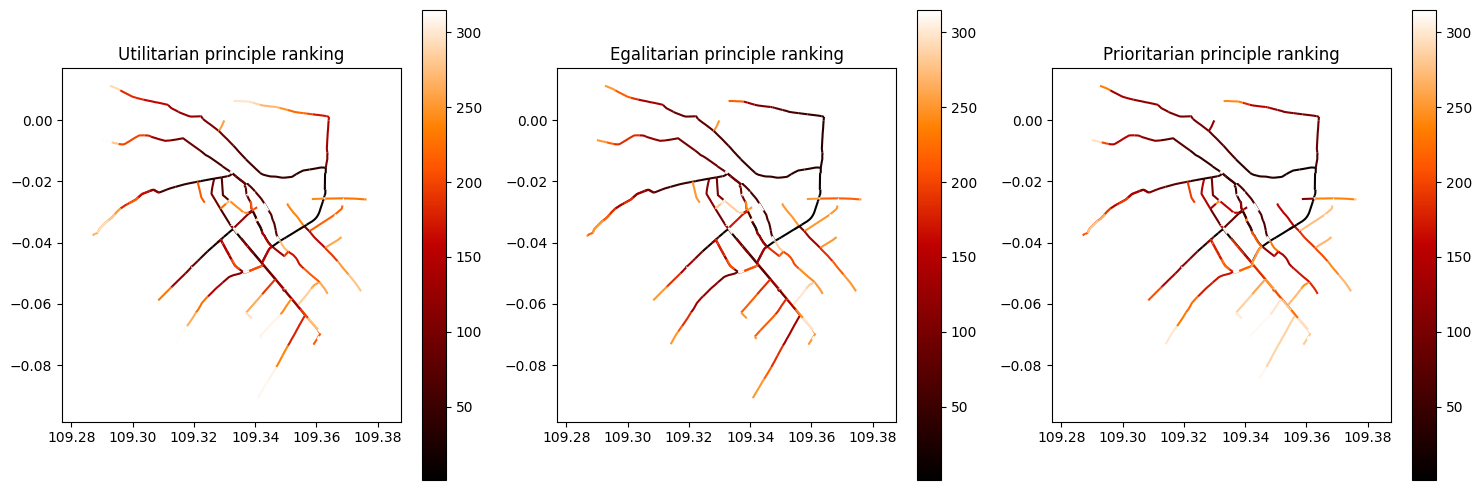

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
gdf.plot(column='traffic_ranked',cmap='gist_heat',ax=axs[0],legend=True)
axs[0].set_title('Utilitarian principle ranking')
gdf.plot(column='traffic_egalitarian_ranked', cmap='gist_heat', ax=axs[1], legend=True)
axs[1].set_title('Egalitarian principle ranking')
gdf.plot(column='traffic_prioritarian_ranked', cmap='gist_heat',ax=axs[2], legend=True)
axs[2].set_title('Prioritarian principle ranking')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



What does this tell us?

The higher the ranking of an edge (values closer to 1), the more critical that part of the network, given the equity principle applied. In the utilitarian principle, this means the most people using that edge. In the egalitarian principle it means having each origin-destination pair having equal opportunity to acces, regardless of how many people live in one origin. In the last principle we correct for the provided equity weight and base the travel calculations on that. This prioritizes more vulnerable areas. 

These insights can be used to for example prioritize network investments. Depending on the service of the network, the prioritization of investments can shift. If investments were to be done based on serving underpiviliged communities, the prioritarian ranking principle can be used, utilizing weights that represent priviliged and underpriviliged areas/communities/regions. As the user is free to specify their own 'equity weights', they can determine their own criteria for prioritization of areas. 

In [15]:
gdf.explore(column='traffic_prioritarian_ranked', tiles="CartoDB positron", cmap='gist_heat')